# Comparison between original model and model with delay

Acapacidade média de atendimento por passo em cada um dos modelos comparados deve ser a mesma. Para isso, o número máxmio de servidores no caso com atraso deve ser igual a $S_d$

$$S_d = t_m \cdot S_o$$

onde $t_m$ é o tempo médio de serviço (1+atraso), $S_o$ é o número de servidores no modelo original sem atrasos.

Para um atraso máximo no serviço de 3 passos ($t_{serM} = 3$), com atrasos distribuidos de maneira uniforme, o $t_m$ seria igual a 3. Para que a comparação seja válida, é necessário que $t_m$ seja um inteiro. Para que isso ocorra, $t_serM$ deve ser ímpar.

$$t_m = \frac{((t_{serM}+1)(t_{serM}+2)/2)-1}{t_{serM}} = \frac{2+3+4}{3} = 3 $$

In [1]:
using JuMP
using HiGHS
using Ipopt
using Juniper

include("utils.jl") # demand_generator_mat, printTable, plotData
include("cc_os_original.jl")
include("cc_om_original.jl")
include("cc_os_delay.jl")
include("cc_om_delay.jl")

cc_om_delay (generic function with 1 method)

### Comon Parametrers

In [ ]:
# Objective function Costs
c_z = 1.5        # weight of served clients
c_ser = 2      # weight of server cost  
c_L = 1

# Objective function
lin_fobj(S, dr, Cin, phi, Z, L) = c_ser*sum(S) - c_z*sum(Z) +c_L*sum(L)

# Parameters
N = 10            # number of examples
horiz = 30        # total horizon

# bounds
XM = 5            # max queue length
YM = 10           # max buffer length before dropping calls
phiM = 9          # max adimission to queue

X = zeros(N, horiz+1)

struct bounds
    XM
    YM
    phiM
    serM  # different for each model
    tserM # only defined for the model with delay
end

# iniital conditions
X0 = 4
Y0 = 6
L0 = 0
Z0 = 1

struct initial_conditions
    X0
    Y0
    L0
    Z0
end
ic = initial_conditions(X0, Y0, L0, Z0)

createDemands = true
if createDemands
    d_mat = demand_generator_mat(1, horiz, 14, "uniform", 1)
    a_mat = demand_generator_mat(1, horiz, 2,"uniform",0.5)  
else
    d_fn = "..//CC_simple//d_mat_Thu_22_May_2025_19_39_50.txt";
    a_fn = "..//CC_simple//a_mat_Thu_22_May_2025_19_39_50.txt";
    d_mat = DelimitedFiles.readdlm(d_fn);
    a_mat = DelimitedFiles.readdlm(a_fn);
    
end

d = d_mat[1:horiz, 1];  # demand for incoming calls
a = a_mat[1:horiz, 1];  # abandonment for calls

struct result
    id
    X
    Y
    Z
    L
    n
    Q
    dr
    phi
    Cin
    Cout
    S
    Sl
    Sa
    Sst
    Sc
    Sin
    Saux
    b_opt
    J
    c_ser
    c_blr
end
   

### Parameters original model

In [3]:
nl = true # true for non linear obj func and false for linear obj func

# costs for the non linear obj func
c_blro = 140
c_sero = 1

serMo = 5  # number of servers

bdso = bounds(XM, YM, phiM, serMo, 0);

### Original model results

In [4]:
optimal, X, Y, Z, L, n, Q, dr, phi, S, b_opt, J = cc_os_original(ic, bdso, c_sero, c_blro, d, a, nl, lin_fobj);
result_os_ori = result("os_ori", X, Y, Z, L, n, Q, dr, phi, nothing, nothing, S, nothing, nothing, nothing, nothing, nothing, nothing, b_opt, J, c_sero, c_blro);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

ok

In [5]:
optimal, X, Y, Z, L, n, Q, dr, phi, S, b_opt, J = cc_om_original(ic, bdso, c_sero, c_blro, d, a, nl, lin_fobj);
result_om_ori = result("om_ori", X, Y, Z, L, n, Q, dr, phi, nothing, nothing, S, nothing, nothing, nothing, nothing, nothing, nothing, b_opt, J, c_sero, c_blro);

ok

### Parameters model with delay

In [6]:
tserM = 3         # max delay in service time
tm = (((tserM+1)*(tserM+2)/2)-1)/tserM # average service time

c_serd = c_sero/tm
c_blrd = c_blro

serMd = serMo*tm         # number of servers
serMd = Int(serMd)
bdsd = bounds(XM, YM, phiM, serMd, tserM)

rnd_tser = true
df_input = df_input_generator(horiz, serMd, tserM, rnd_tser);

### Delay model results

In [7]:
optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sa, Sst, Sc, Sin, Saux, b_opt, J = cc_os_delay(ic, bdsd, a, d, df_input, lin_fobj);
result_os_del = result("os_del", X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sa, Sst, Sc, Sin, Saux, b_opt, J, c_serd, c_blrd);

In [8]:
optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sa, Sst, Sc, Sin, Saux, b_opt, J = cc_om_delay(ic, bdsd, a, d, df_input, lin_fobj);
result_om_del = result("om_del", X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sa, Sst, Sc, Sin, Saux, b_opt, J, c_serd, c_blrd);

ok

## Results comparison

In [9]:
results_list = [result_os_ori, result_om_ori, result_os_del, result_om_del]

for res in results_list
    # br = res.L[horiz+1]/(res.L[horiz+1]+res.Z[horiz+1])
    br = sum(res.L./(res.L.+res.Z)) # VERIFICAR QUAL A MELHOR FORMA DE CALCULAR
    total_clients = res.Z[horiz+1]
    cost = res.c_ser*sum(res.S) + res.c_blr*br

    println(res.id)
    data = hcat(br, total_clients, cost)
    header = (["br", "total clients", "cost"]);
    printTable(data, header)
end

os_ori
Results
┌────────┬───────────────┬──────────┐
│     br │ total clients │     cost │
├────────┼───────────────┼──────────┤
│ 11.935 │        79.000 │ 1748.898 │
└────────┴───────────────┴──────────┘
om_ori
Results
┌───────┬───────────────┬──────────┐
│    br │ total clients │     cost │
├───────┼───────────────┼──────────┤
│ 8.352 │       134.000 │ 1302.327 │
└───────┴───────────────┴──────────┘
os_del
Results
┌────────┬───────────────┬──────────┐
│     br │ total clients │     cost │
├────────┼───────────────┼──────────┤
│ 10.922 │       121.000 │ 1642.801 │
└────────┴───────────────┴──────────┘
om_del
Results
┌───────┬───────────────┬──────────┐
│    br │ total clients │     cost │
├───────┼───────────────┼──────────┤
│ 7.177 │       143.000 │ 1126.175 │
└───────┴───────────────┴──────────┘


In [10]:
function plot_results(res, horiz)
    # println(res.id)
    evolution = [res.X[1:horiz,1], res.Z[1:horiz,1], res.S[1:horiz,1], res.L[1:horiz,1]]
    ylabel = [L"X" L"Z" L"S" L"L"]
    title = ["queue occupancy" "total customers" "active servers" "lost customers"]
    plotData(evolution, ylabel, title)
end

plot_results (generic function with 1 method)

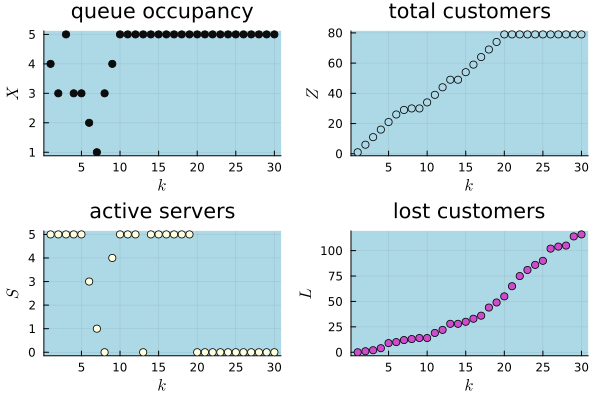

In [11]:
plot_results(result_os_ori, horiz)

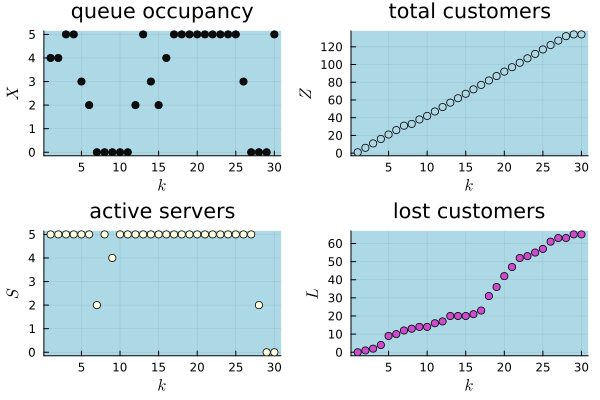

In [12]:
plot_results(result_om_ori, horiz)

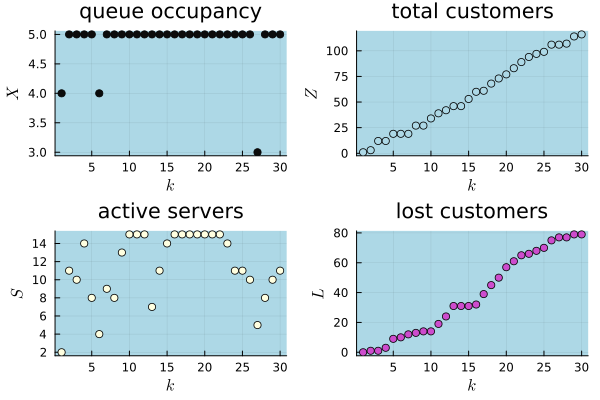

In [13]:
plot_results(result_os_del, horiz)

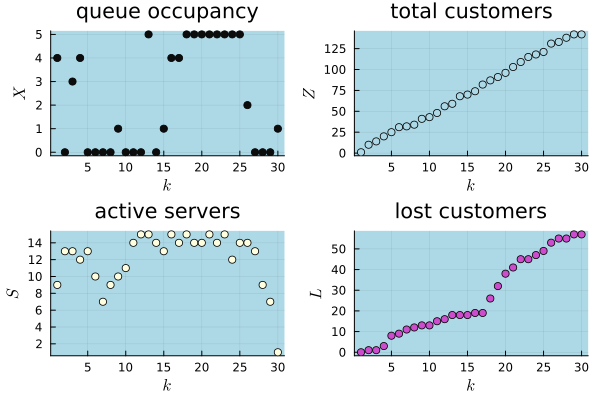

In [14]:
plot_results(result_om_del, horiz)